In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from glob import glob
import re
from pathlib import Path

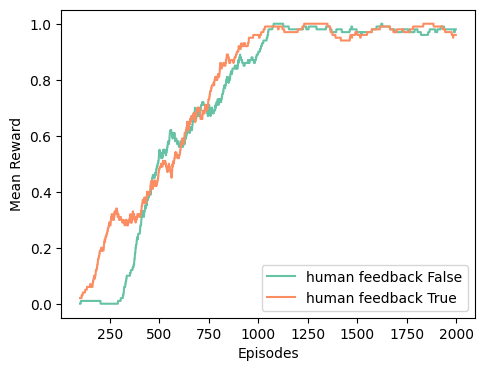

In [47]:
import json
from io import StringIO


def folders_and_params(filters={}):
    folders = []
    folder_params = []
    log_dir = Path("logs")
    for folder in log_dir.glob("*"):
        with open(folder / "params.json") as fd:
            params = json.load(fd)

            should_add = True
            for k, v in filters.items():
                if params[k] != v:
                    should_add = False

            if should_add:
                folders.append(folder)
                folder_params.append(params)

    ret = list(zip(folders, folder_params))
    ret.sort(key=lambda x: x[0])

    return ret


def read_monitor_data(monitor_folder, rolling_length=100):
    # monitor_folder = f / "monitor"
    monitor_files = list(monitor_folder.glob("*.csv"))
    merged_monitor_data = ""
    for monitor_file in monitor_files:
        with open(monitor_file, "r") as fd:
            cmt = fd.readline()
            hdr = fd.readline()
            if merged_monitor_data == "":
                merged_monitor_data += cmt
                merged_monitor_data += hdr
            merged_monitor_data += fd.read()

    df = pd.read_csv(StringIO(merged_monitor_data), skiprows=1)
    df = df.sort_values("t")

    df["steps"] = df["l"].cumsum()

    mean_rewards = df["r"].rolling(rolling_length).mean().to_list()
    steps = df["steps"].tolist()

    return mean_rewards, steps


figsize = np.array([6.4, 4.8]) / 1.2


def plot_learning_curve(folders_and_params, labels, max_length=-1, rolling_length=100):
    plt.figure(figsize=figsize)
    colors = sns.color_palette("Set2", len(folders_and_params))
    for (f, p), l, c in zip(folders_and_params, labels, colors):
        mean_rewards, steps = read_monitor_data(f, rolling_length=rolling_length)

        # if len(steps) > 16:
        #     steps = steps[2::4]
        #     mean_rewards = mean_rewards[2::4]

        if max_length < 0:
            max_length = len(steps)
        plt.plot(
            mean_rewards[:max_length],
            label=l,
            color=c,
        )

    plt.legend()
    plt.xlabel("Episodes")
    plt.ylabel("Mean Reward")


fnp = [(f, p) for f, p in folders_and_params({}) if "2024-05-02_15-18" in str(f)]
# fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = [f"human feedback {p['human_feedback']}" for f, p in fnp]
plot_learning_curve(fnp, labels, max_length=2000)

<function <lambda> at 0x731f660f13f0>


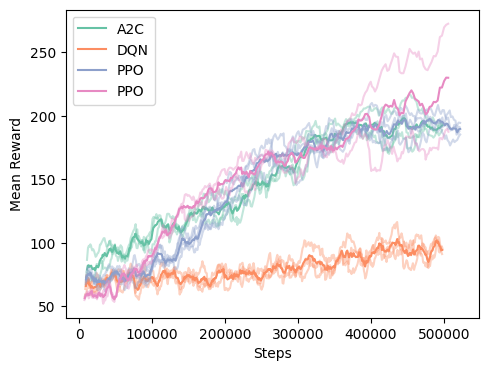

In [35]:
def plot_average_learning_curve(folders_and_params, labels):
    plt.figure(figsize=figsize)
    params = [p for f, p in folders_and_params]
    for i in range(len(params)):
        params[i]["seed"] = 0

    params_set = []
    for p in params:
        if p not in params_set:
            params_set.append(p)

    colors = sns.color_palette("Set2", len(params_set))
    # colors = sns.color_palette()

    for i, p_group in enumerate(params_set):
        group_steps = []
        group_mean_rewards = []

        good_p = {}
        for f, p in folders_and_params:
            p["seed"] = 0
            if p_group == p:
                good_p = p
                mean_rewards, steps = read_monitor_data(f)
                mean_rewards = mean_rewards[::10]
                steps = steps[::10]

                group_steps.append(steps)
                group_mean_rewards.append(mean_rewards)

                plt.plot(
                    steps, mean_rewards,
                    color = colors[i], alpha=0.4
                )

        average_mean_rewards = []
        for step in group_steps[0]:
            average_mean_rewards.append(
                np.mean([g[np.argmin([np.abs(step - s) for s in group_steps[i]])] for i, g in enumerate(group_mean_rewards)])
            )

        plt.plot(
            group_steps[0], average_mean_rewards, label=labels(f, good_p),
            color = colors[i]
        )

    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")

fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learning_rate": 0.0003,
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
]
fnp.sort(key=lambda x: x[1]["learningAlg"])
labels = lambda f, p: f"{p['learningAlg']}"

print(labels)
plot_average_learning_curve(fnp, labels)

plt.savefig("../report/figures/compare_alg.png")